MEG/EEG analysis: data computation
================================================

`

In [1]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import mne
mne.set_log_level('WARNING')

## Extract MEG data of interest for source analysis

In [3]:
import os
from mne.datasets import sample
# data_path = '/tsi/doctorants/data_gramfort/data_advneuro/'
data_path = None  # USE THIS LINE IF YOU ARE NOT ON THE TELECOM NETWORK
data_path = sample.data_path(data_path)
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)

### Define epochs and compute ERP/ERF

In [4]:
events = mne.find_events(raw, stim_channel='STI 014')

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                            exclude='bads')
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)
print(epochs)

<Epochs  |   72 events (good & bad), -0.199795 - 0.499488 sec, baseline [None, 0], ~3.5 MB, data not loaded,
 'aud_l': 72>


## Compute noise covariance



- Using the `mne.compute_covariance` function compute the noise covariance during baseline.
- If we want to solve inverse-problem,we must take noise into consideration
- Plot the estimated noise covariance matrices using `mne.viz.plot_cov`

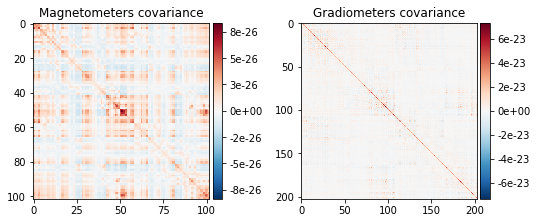

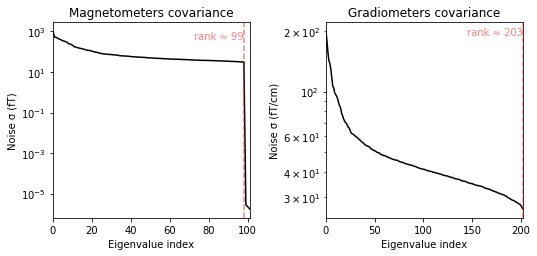

(<Figure size 547.2x266.4 with 4 Axes>, <Figure size 547.2x266.4 with 2 Axes>)

In [27]:
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0,
                                   method='empirical')
mne.viz.plot_cov(noise_cov,raw.info)

## Compute the evoked response

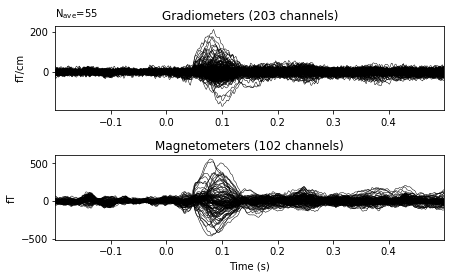

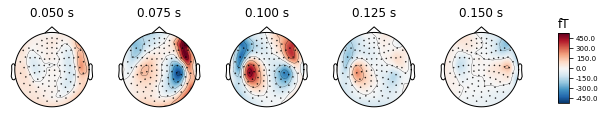

In [7]:
evoked = epochs.average()
evoked.plot()
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag');

## Inverse modeling: MNE and dSPM on evoked data

The goal now is to compute source estimates from evoked data using the dSPM source localization method.

This will produce files called "stc" files that we will load in `mne_analyze` for visualization and exploration.

Import the required functions:

In [8]:
from mne.forward import read_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse

## Read the forward solution and compute the inverse operator

In [9]:
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)
fwd = mne.convert_forward_solution(fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an M/EEG, MEG-only, and EEG-only inverse operators
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

In [10]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)
print(stc)

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 1.6649601096532323 (ms), data shape : (7498, 421)>


In [11]:
stc.data.shape

(7498, 421)

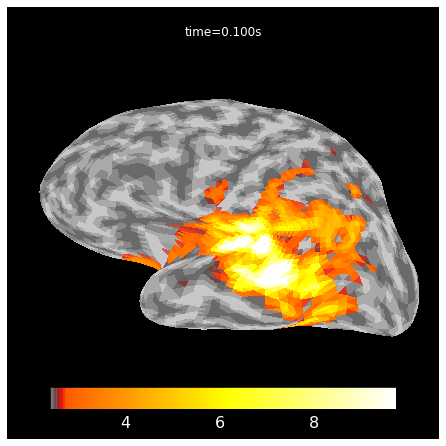

In [25]:
initial_time = 0.1
subjects_dir = data_path + '/subjects/'
mpl_fig = stc.plot(subjects_dir=subjects_dir, initial_time=initial_time,
                   backend='matplotlib', verbose='error')